In [1]:
# import packages
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sg
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
from sklearn.mixture import GaussianMixture
from scipy import stats

In [2]:
def addLag(dataset, maxlag):
    # return the full dataset with lag
    LAG = np.arange(1,maxlag + 1)
    lagdata = pd.DataFrame([])
    for lag in LAG:
        varname = 'lag' + str(lag)
        lagdata[varname] = dataset['arrival'].loc[maxlag-lag:len(dataset)-lag-1].reset_index(drop = True)
    dataset = pd.concat([dataset.loc[maxlag:].reset_index(drop = True), lagdata.reset_index(drop = True)], axis = 1, sort = False)
    return dataset

In [3]:
FACILITY = ['JFK','LGA','PENN']
TRAFFIC = ['vehicle']
DATA = {}
for facility in FACILITY:
    dataset = pd.read_csv(facility + '.csv')
    DATA[facility] = addLag(dataset, 12)

In [4]:
arimaParams = {'JFKvehicle': [4,0], 'LGAvehicle': [6,0], 'PENNvehicle': [1,0]}

JFKvehicle


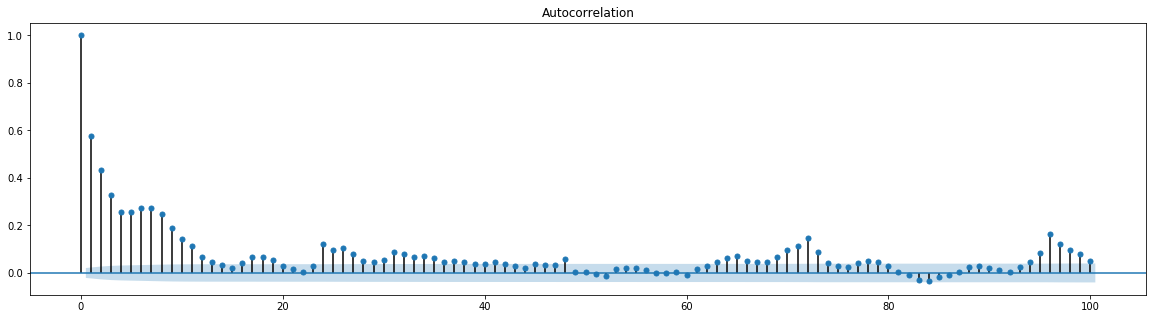

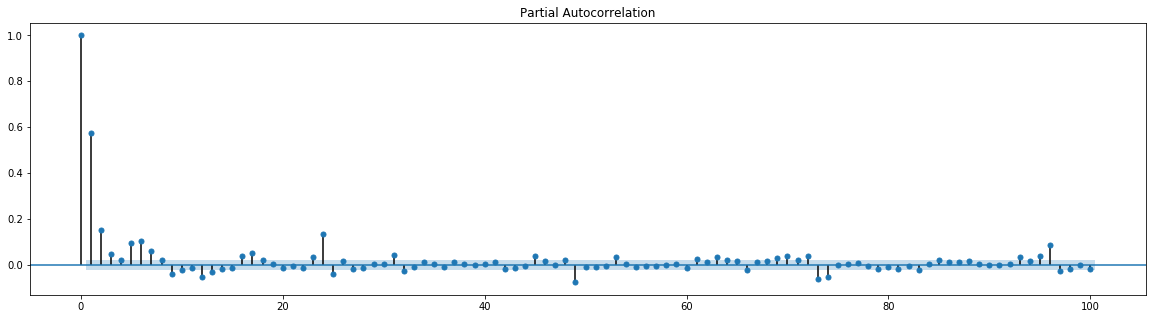

LGAvehicle


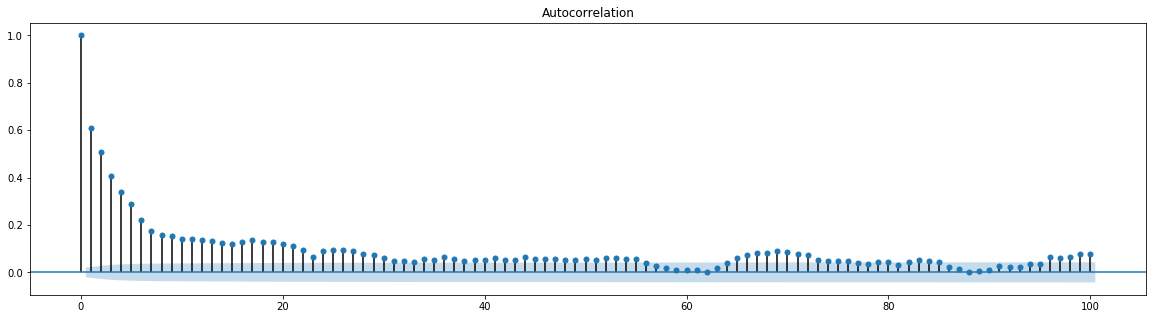

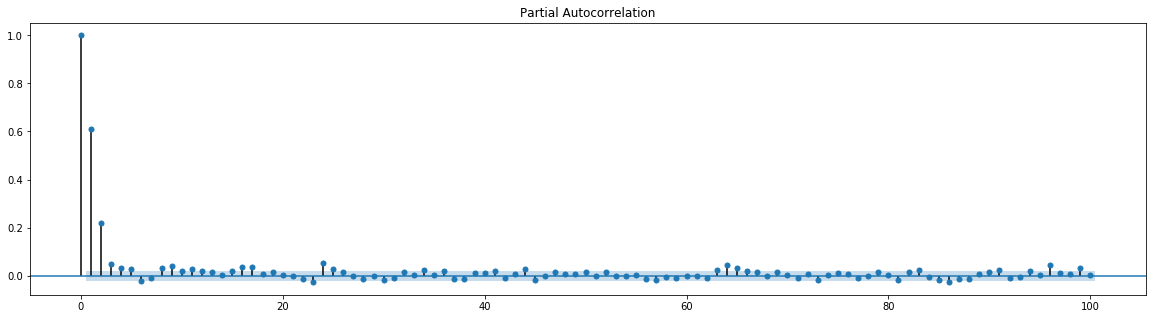

PENNvehicle


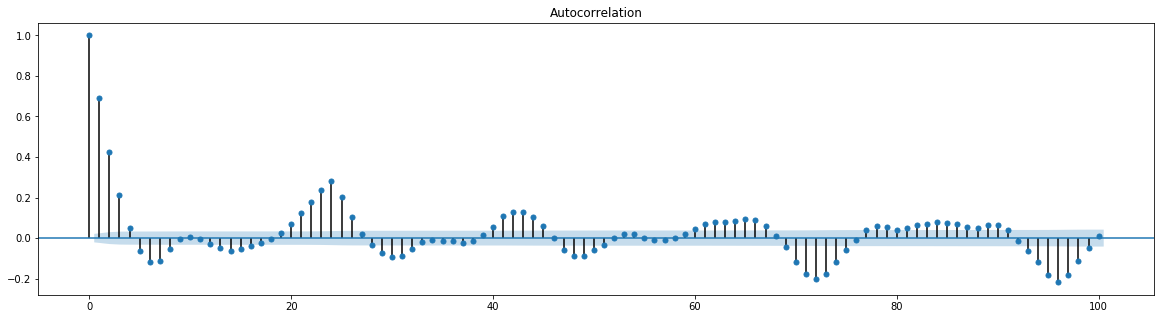

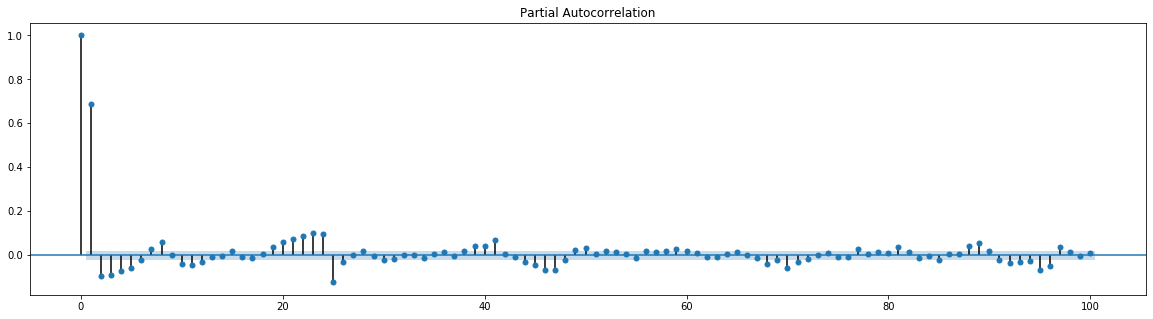

In [5]:

RESIDUE = {}
FINALRESID = pd.DataFrame({})
FINALLOGRESID = pd.DataFrame({})
LINEARPREDICT = pd.DataFrame({})
TOTALPREDICT = pd.DataFrame({})
R2LINEAR = {}
R2FINAL = {}

base = dt.datetime(2018,1,1)
date = [] # date list for every one
for i in range(12,365 * 24):
    time = base + dt.timedelta(hours = i)
    date.append(time)

for facility in FACILITY:
    for traffic in TRAFFIC:
        example = pd.DataFrame({})
        key = facility + traffic
        print(key)
        featureData = DATA[facility].drop(['date','yellow','fhv','vehicle'], axis = 1)
        feature = featureData.columns.values.tolist()
        featureString = ''
        for i in range(0,len(feature)):
            featureString = featureString + '+' + feature[i]
        linearModel = smf.ols(formula = traffic + ' ~ ' + featureString, data = DATA[facility]).fit()
        residue = linearModel.resid
        linearpredict = linearModel.predict(featureData)
        LINEARPREDICT[key] = linearpredict
        R2LINEAR[key] = linearModel.rsquared
        p = arimaParams[key][0]
        q = arimaParams[key][1]
        # plot ACF and PACF 
        fig, ax = plt.subplots(1, figsize = (20, 5))
        sg.plot_acf(residue, ax = ax, lags = 100)
        plt.show()
        fig, ax = plt.subplots(1, figsize = (20, 5))
        # sg.plot_acf(Series, ax=ax, lags=250)
        sg.plot_pacf(residue, ax = ax, lags = 100)
        plt.show()
        arima_model = ARIMA(residue, order = (p, 0, q))
        arima_model_fit = arima_model.fit(disp = 0) 
        arimapredict = arima_model_fit.predict(start = 0, end = len(residue) - 1)
        FINALRESID[key] = arima_model_fit.resid
        # calculate the overall r2
        y = np.array(DATA[facility][traffic])
        R2FINAL[key] = 1 - (np.sum(np.array(FINALRESID[key])**2) / np.sum((y - np.mean(y)) **2 ))
        TOTALPREDICT[key] = linearpredict + arimapredict
        FINALLOGRESID[key] = np.log(np.abs(TOTALPREDICT[key] - y))
        example['observation'] = DATA[facility]['vehicle']
        example['prediction'] = TOTALPREDICT[key]
        example['date'] = date
        example.to_csv(facility + 'example.csv')

In [6]:
# example dataframe to give
example = pd.DataFrame({})
key = 'JFKvehicle'
example['observation'] = DATA['JFK']['vehicle']
example['prediction'] = TOTALPREDICT[key]
example['residue'] = FINALRESID[key]
example['logresidue'] = FINALLOGRESID[key]
example.to_csv('JFKexample.csv')

In [7]:
print('This is the R2 from single linear model')
for key, value in R2LINEAR.items():
    print(key)
    print(value)
print('This is the R2 from hybrid model')
for key, value in R2FINAL.items():
    print(key)
    print(value)

This is the R2 from single linear model
JFKvehicle
0.8130146692249665
LGAvehicle
0.8813972522386017
PENNvehicle
0.7215609848162579
This is the R2 from hybrid model
JFKvehicle
0.8780396290904879
LGAvehicle
0.929497161070105
PENNvehicle
0.8537424495161638


In [8]:
holidaydata = pd.read_csv('nycevent2018.csv')
holidaydate = []
for i in range(0, len(holidaydata)):
    datestr = holidaydata['Date'].iloc[i]
    holidaydate.append(dt.datetime.strptime(datestr, "%y/%m/%d"))
holidaydata['date'] = holidaydate
holidaydata = holidaydata.drop(['Date'], axis = 1)
holidaydata.head(15)

FileNotFoundError: [Errno 2] File b'nycevent2018.csv' does not exist: b'nycevent2018.csv'

In [ ]:
# deteect anomalies

    
ANOMALYDETECTION = {}
for facility in FACILITY:
    for traffic in TRAFFIC:
        anomalydetection = pd.DataFrame({'date': date})
        ifanomaly = np.zeros(len(date))
        for pval in [0.001, 0.005, 0.1]:
            key = facility + traffic
            print(key + ' in thre:' + str(pval))
            ydata = FINALLOGRESID[key]
            ydata = np.array(ydata).reshape(-1, 1) # required by GMM
            gm = GaussianMixture(n_components = 4, n_init = 100, max_iter = 1000, random_state = 0)
            clustering = gm.fit(ydata)
            anomalydetection['likelihood'] = np.exp(clustering.score_samples(ydata))
            print(stats.describe(anomalydetection['likelihood']))
            thre = sorted(anomalydetection['likelihood'])[int(len(anomalydetection['likelihood']) * pval)]
            for i in range(0, len(ydata)):
                if anomalydetection['likelihood'].iloc[i] < thre:
                    ifanomaly[i] = 1
            anomalydetection['ifanomaly'] = ifanomaly
            detected = anomalydetection[anomalydetection['ifanomaly'] == 1]
            detectedDay = []
            for i in range(0, len(detected['date'])):
                detectedDay.append(detected['date'].iloc[i].date())
            intersection = set(holidaydate) & set(detectedDay)
            print(detectedDay)
            intersection_in_anomaly = len(intersection) / len(detectedDay)
            intersection_in_holiday = len(intersection) / len(holidaydate)
            print(intersection_in_anomaly)
            print(intersection_in_holiday)